Creating scientific snow analysis for 2023-02-22 12:00
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2023-Feb-22 12:00 UTC F00 ┊ GRIB2 @ local ┊ IDX @ aws
Found 6 snow-related variables
Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
Creating scientific multi-panel snow analysis...
Scientific snow analysis saved as ./snow_depth_analysis/scientific_snow_analysis_2023-02-22_1200.png


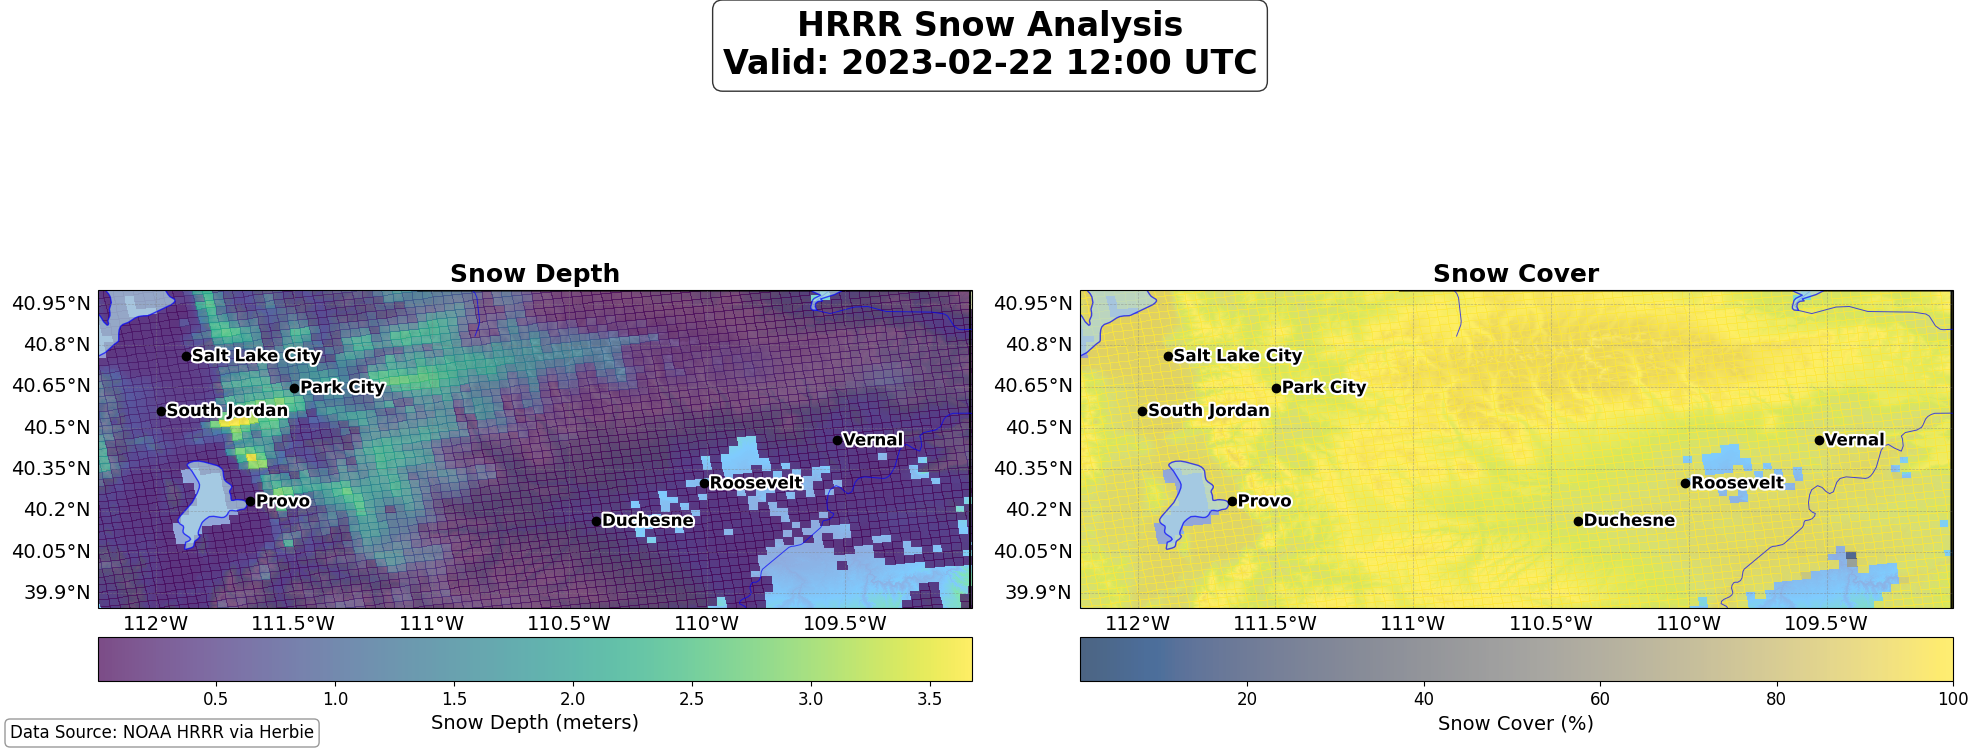

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from herbie import Herbie
import numpy as np
import os
import xarray as xr
import pandas as pd
from datetime import datetime, timedelta
import warnings
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.patheffects as patheffects

# Set scientific style
plt.style.use('default')
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.titlesize': 24
})

warnings.filterwarnings('ignore')


def load_dem_data(lon_min, lon_max, lat_min, lat_max):
    """Load Digital Elevation Model (DEM) data for the given region."""
    import rasterio
    from rasterio.warp import transform_bounds

    dem_file = "/Users/a02428741/PycharmProjects/snowshadow/notebooks/uinta_dem_data/merged_dem.tif"

    if not os.path.exists(dem_file):
        return None, None, None

    with rasterio.open(dem_file) as src:
        # Transform the bounds to the CRS of the raster
        dst_crs = src.crs
        src_crs = 'EPSG:4326'  # WGS84
        transformed_bounds = transform_bounds(src_crs, dst_crs, lon_min, lat_min, lon_max, lat_max)

        # Read the data within the transformed bounds
        window = src.window(*transformed_bounds)
        dem = src.read(1, window=window)

        # Get the transform for the windowed data
        win_transform = src.window_transform(window)

        # Calculate longitude and latitude arrays
        height, width = dem.shape
        lon = np.linspace(win_transform.c, win_transform.c + width * win_transform.a, width)
        lat = np.linspace(win_transform.f, win_transform.f + height * win_transform.e, height)

        return dem, lon, lat


def handle_multiple_datasets(datasets_list, variable_pattern):
    """Helper function to handle a list of datasets and find the desired variable."""
    for i, ds in enumerate(datasets_list):
        # Find variables that match our pattern
        matching_vars = [var for var in ds.data_vars if variable_pattern.lower() in var.lower()]

        if matching_vars:
            return ds, matching_vars[0]

    return None, None


def extract_region_data(ds, var_name, bbox):
    """Extract region data for the specified dataset and variable"""
    if ds is None or var_name is None:
        return None, None, None

    lat_min, lon_min, lat_max, lon_max = bbox

    # Identify coordinate names
    if 'latitude' in ds.coords and 'longitude' in ds.coords:
        lat_coord, lon_coord = 'latitude', 'longitude'
    elif 'lat' in ds.coords and 'lon' in ds.coords:
        lat_coord, lon_coord = 'lat', 'lon'
    else:
        return None, None, None

    # Convert longitudes if necessary (HRRR uses 0-360 sometimes)
    if ds[lon_coord].min() > 180:
        ds = ds.assign_coords({lon_coord: (((ds[lon_coord] + 180) % 360) - 180)})

    # Check if coordinates are 1D or 2D
    if ds[lat_coord].ndim == 1 and ds[lon_coord].ndim == 1:
        # 1D coordinates can use direct selection
        ds_region = ds.sel({lat_coord: slice(lat_max, lat_min),
                            lon_coord: slice(lon_min, lon_max)})
    else:
        # 2D coordinates need to use masking
        # Create a mask for the region of interest
        lat_mask = (ds[lat_coord] >= lat_min) & (ds[lat_coord] <= lat_max)
        lon_mask = (ds[lon_coord] >= lon_min) & (ds[lon_coord] <= lon_max)
        combined_mask = lat_mask & lon_mask

        # Find the indices where the mask is True
        y_indices, x_indices = np.where(combined_mask)
        if len(y_indices) > 0 and len(x_indices) > 0:
            y_min, y_max = y_indices.min(), y_indices.max()
            x_min, x_max = x_indices.min(), x_indices.max()
            ds_region = ds.isel(y=slice(y_min, y_max + 1), x=slice(x_min, x_max + 1))
        else:
            ds_region = ds

    return ds_region, lat_coord, lon_coord


def get_valid_time_str(ds, date_str):
    """Get the valid time as string from dataset."""
    if ds is None:
        return date_str

    if hasattr(ds, 'valid_time'):
        valid_time = ds.valid_time
        if hasattr(valid_time, 'dt'):
            return valid_time.dt.strftime('%Y-%m-%d %H:%M UTC').item()
        else:
            return str(valid_time)
    elif 'time' in ds.coords:
        return str(ds['time'].values.item())
    else:
        return date_str


def setup_map_and_features(ax, bbox, projection, dem_data=None, dem_lon=None, dem_lat=None):
    """Setup the axes with basic map features and cities."""
    lat_min, lon_min, lat_max, lon_max = bbox

    # Set the extent
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=projection)

    # Add terrain first
    if dem_data is not None and dem_lon is not None and dem_lat is not None:
        # Use DEM data if available
        terrain = ax.pcolormesh(dem_lon, dem_lat, dem_data,
                                cmap='terrain', alpha=0.5,
                                transform=projection)
    else:
        # Use basic features instead of terrain
        ax.add_feature(cfeature.LAND.with_scale('10m'), facecolor='#edeae2')
        ax.add_feature(cfeature.OCEAN.with_scale('10m'), facecolor='lightblue')

    # Add other features
    ax.add_feature(cfeature.STATES.with_scale('10m'), edgecolor="black", linewidth=1.5, facecolor="none", alpha=0.8)
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), edgecolor="black", linewidth=1.5)
    ax.add_feature(cfeature.RIVERS.with_scale('10m'), edgecolor='blue', linewidth=0.7, alpha=0.7)
    ax.add_feature(cfeature.LAKES.with_scale('10m'), edgecolor='blue', facecolor='lightblue', alpha=0.7)

    # Add gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

    # Add cities
    cities = {
        # Wasatch Front
        "Salt Lake City": (40.7608, -111.8910),
        "Provo": (40.2338, -111.6585),
        "South Jordan": (40.5622, -111.9829),
        "Ogden": (41.2230, -111.9738),
        "Logan": (41.7370, -111.8338),
        "Park City": (40.6461, -111.4980),
        # Uinta Basin
        "Duchesne": (40.1635, -110.4029),
        "Roosevelt": (40.2994, -110.0126),
        "Vernal": (40.4555, -109.5287),
        # Other notable locations
        "Wendover": (40.7372, -114.0370),
        "Moab": (38.5733, -109.5498)
    }

    for city, (lat, lon) in cities.items():
        if (lon >= lon_min and lon <= lon_max and lat >= lat_min and lat <= lat_max):
            ax.plot(lon, lat, 'ko', markersize=6, transform=projection)
            ax.text(lon, lat, f" {city}", fontsize=12,
                    transform=projection,
                    verticalalignment='center', fontweight='bold',
                    path_effects=[patheffects.withStroke(linewidth=3, foreground='white')])

    return ax


def download_and_visualize_snow_depth(date_str, output_dir="./snow_depth_analysis",
                                      bbox=(39.746002, -112.016602, 40.993115, -109.083252),
                                      create_multiplot=True):
    """Download and visualize HRRR snow depth data for a specific date and bounding box."""
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Create a safe filename from the date string
    date_safe = date_str.replace(' ', '_').replace(':', '')

    # Extract bounding box coordinates
    lat_min, lon_min, lat_max, lon_max = bbox

    print(f"Downloading HRRR data for {date_str}...")

    # Initialize Herbie for HRRR model
    H = Herbie(date_str, model="hrrr", product="sfc", fxx=0)

    # Download the GRIB2 file
    file_path = H.download()

    if not os.path.exists(file_path):
        print(f"File download failed. File not found at: {file_path}")
        return

    # Get inventory to see available variables
    inventory = H.inventory()

    # Look for snow-related variables
    snow_vars_info = []
    for idx, row in inventory.iterrows():
        var_name = row['variable']
        level = row['level']
        search_this = row['search_this']

        # Check for snow-related variables
        if ('SNOW' in var_name or 'SNOD' in var_name or 'WEASD' in var_name) and idx < 100:
            search_string = f"{var_name}:{level}"
            if ':' in search_this:
                search_string = search_this.split(':')[1] + ':' + search_this.split(':')[2]
            snow_vars_info.append((var_name, level, search_string))

    if not snow_vars_info:
        print("No snow-related variables found.")
        return

    print(f"Found {len(snow_vars_info)} snow-related variables")

    # Extract snow depth data (SNOD)
    snod_ds = None
    snod_var = None

    snod_result = H.xarray("SNOD:surface")

    # Handle if it returns a list of datasets
    if isinstance(snod_result, list):
        snod_ds, snod_var = handle_multiple_datasets(snod_result, "snod")
    else:
        snod_ds = snod_result
        if snod_ds and len(snod_ds.data_vars) > 0:
            snod_var = list(snod_ds.data_vars)[0]

    if snod_ds is not None and snod_var is not None:
        # Check data range
        data_min = float(snod_ds[snod_var].min().values)
        data_max = float(snod_ds[snod_var].max().values)
        non_zero = (snod_ds[snod_var].values != 0).sum()

        if data_max <= 0.01 and non_zero < 100:
            snod_ds = None
            snod_var = None

    # Extract snow water equivalent data (WEASD)
    weasd_ds = None
    weasd_var = None

    weasd_result = H.xarray("WEASD:surface")

    # Handle if it returns a list of datasets
    if isinstance(weasd_result, list):
        weasd_ds, weasd_var = handle_multiple_datasets(weasd_result, "weasd")
    else:
        weasd_ds = weasd_result
        if weasd_ds and len(weasd_ds.data_vars) > 0:
            weasd_var = list(weasd_ds.data_vars)[0]

    if weasd_ds is not None and weasd_var is not None:
        # Check data range
        data_min = float(weasd_ds[weasd_var].min().values)
        data_max = float(weasd_ds[weasd_var].max().values)
        non_zero = (weasd_ds[weasd_var].values != 0).sum()

        if data_max <= 0.01 and non_zero < 100:
            weasd_ds = None
            weasd_var = None

    # Extract snow cover data (SNOWC)
    snowc_ds = None
    snowc_var = None

    snowc_result = H.xarray("SNOWC:surface")

    # Handle if it returns a list of datasets
    if isinstance(snowc_result, list):
        snowc_ds, snowc_var = handle_multiple_datasets(snowc_result, "snowc")
    else:
        snowc_ds = snowc_result
        if snowc_ds and len(snowc_ds.data_vars) > 0:
            snowc_var = list(snowc_ds.data_vars)[0]

    if snowc_ds is not None and snowc_var is not None:
        # Check data range
        data_min = float(snowc_ds[snowc_var].min().values)
        data_max = float(snowc_ds[snowc_var].max().values)
        non_zero = (snowc_ds[snowc_var].values != 0).sum()

        if data_max <= 1 and non_zero < 100:
            snowc_ds = None
            snowc_var = None

    # Check if we have any snow data
    if snod_ds is None and weasd_ds is None and snowc_ds is None:
        print("No valid snow data found for this date.")
        return

    # Extract region data for each dataset
    snod_region, snod_lat, snod_lon = extract_region_data(snod_ds, snod_var, bbox)
    weasd_region, weasd_lat, weasd_lon = extract_region_data(weasd_ds, weasd_var, bbox)
    snowc_region, snowc_lat, snowc_lon = extract_region_data(snowc_ds, snowc_var, bbox)

    # Get the valid time string (use the first available dataset)
    for ds in [snod_region, weasd_region, snowc_region]:
        if ds is not None:
            valid_time_str = get_valid_time_str(ds, date_str)
            break
    else:
        valid_time_str = date_str

    # Load DEM data for the region
    dem_data, dem_lon, dem_lat = load_dem_data(lon_min, lon_max, lat_min, lat_max)

    # Create a multi-panel figure if requested
    if create_multiplot and sum(x is not None for x in [snod_region, weasd_region, snowc_region]) > 1:
        print("Creating scientific multi-panel snow analysis...")

        # Determine how many panels we need
        panel_count = sum(x is not None for x in [snod_region, weasd_region, snowc_region])

        # Set up the figure and axes
        projection = ccrs.PlateCarree()

        if panel_count == 2:
            fig, axes = plt.subplots(1, 2, figsize=(20, 8),
                                     subplot_kw={'projection': projection})
            if not isinstance(axes, np.ndarray):
                axes = np.array([axes])
        else:
            fig, axes = plt.subplots(2, 2, figsize=(20, 16),
                                     subplot_kw={'projection': projection})
            axes = axes.flatten()

        # Initialize panel index
        panel_idx = 0

        # Process SNOD (Snow Depth) if available
        if snod_region is not None and snod_var is not None:
            ax = axes[panel_idx]
            panel_idx += 1

            # Setup map and features
            ax = setup_map_and_features(ax, bbox, projection, dem_data, dem_lon, dem_lat)

            # Keep in meters for scientific presentation
            data_to_plot = snod_region[snod_var]
            units = 'meters'

            # Create custom colormap for snow depth
            snow_cmap = plt.cm.get_cmap('viridis')
            vmin = max(0.003, float(data_to_plot.min().values))  # 3mm threshold
            vmax = max(0.03, float(data_to_plot.max().values))

            # Apply a mask to hide zero or near-zero values
            masked_data = data_to_plot.where(data_to_plot > vmin)

            # Plot the data
            p = ax.pcolormesh(snod_region[snod_lon], snod_region[snod_lat], masked_data,
                              cmap=snow_cmap, transform=projection, vmin=vmin, alpha=0.7)

            # Add color bar
            cbar = plt.colorbar(p, ax=ax, orientation="horizontal", pad=0.05)
            cbar.set_label(f"Snow Depth ({units})", fontsize=14)
            cbar.ax.tick_params(labelsize=12)

            # Add title
            ax.set_title("Snow Depth", fontsize=18, fontweight='bold')

        # Process WEASD (Snow Water Equivalent) if available
        if weasd_region is not None and weasd_var is not None:
            ax = axes[panel_idx]
            panel_idx += 1

            # Setup map and features
            ax = setup_map_and_features(ax, bbox, projection, dem_data, dem_lon, dem_lat)

            # Keep in kg/m² for scientific presentation
            data_to_plot = weasd_region[weasd_var]
            units = 'kg/m²'

            # Create custom colormap for SWE
            swe_cmap = plt.cm.get_cmap('plasma')
            vmin = max(0.003, float(data_to_plot.min().values))  # 3mm threshold
            vmax = max(0.015, float(data_to_plot.max().values))

            # Apply a mask to hide zero or near-zero values
            masked_data = data_to_plot.where(data_to_plot > vmin)

            # Plot the data
            p = ax.pcolormesh(weasd_region[weasd_lon], weasd_region[weasd_lat], masked_data,
                              cmap=swe_cmap, transform=projection, vmin=vmin, alpha=0.7)

            # Add color bar
            cbar = plt.colorbar(p, ax=ax, orientation="horizontal", pad=0.05)
            cbar.set_label(f"Snow Water Equivalent ({units})", fontsize=14)
            cbar.ax.tick_params(labelsize=12)

            # Add title
            ax.set_title("Snow Water Equivalent", fontsize=18, fontweight='bold')

        # Process SNOWC (Snow Cover) if available
        if snowc_region is not None and snowc_var is not None:
            ax = axes[panel_idx]
            panel_idx += 1

            # Setup map and features
            ax = setup_map_and_features(ax, bbox, projection, dem_data, dem_lon, dem_lat)

            # Snow cover is already in percentage
            data_to_plot = snowc_region[snowc_var]
            units = '%'

            # Create a customized colormap for snow cover
            snowc_cmap = plt.cm.get_cmap('cividis')
            snowc_norm = plt.Normalize(vmin=1, vmax=100)

            # Apply a mask to hide zero or near-zero values
            masked_data = data_to_plot.where(data_to_plot > 1)

            # Plot the data
            p = ax.pcolormesh(snowc_region[snowc_lon], snowc_region[snowc_lat], masked_data,
                              cmap=snowc_cmap, transform=projection, norm=snowc_norm, alpha=0.7)

            # Add color bar
            cbar = plt.colorbar(p, ax=ax, orientation="horizontal", pad=0.05)
            cbar.set_label(f"Snow Cover ({units})", fontsize=14)
            cbar.ax.tick_params(labelsize=12)

            # Add title
            ax.set_title("Snow Cover", fontsize=18, fontweight='bold')

        # If we have all three variables, create a combined analysis in the fourth panel
        if panel_count == 3 and panel_idx == 3:
            ax = axes[panel_idx]

            # Setup map and features
            ax = setup_map_and_features(ax, bbox, projection, dem_data, dem_lon, dem_lat)

            # Create a classified map based on snow depth or snow cover
            if snod_region is not None and snod_var is not None:
                # Use snow depth for classification - keep in meters
                base_data = snod_region[snod_var]

                # Create classification bins (in meters)
                snow_classes = np.zeros_like(base_data)
                snow_classes = xr.where(base_data > 0.003, 1, snow_classes)  # Light snow: > 3mm
                snow_classes = xr.where(base_data > 0.025, 2, snow_classes)  # Moderate snow: > 2.5cm
                snow_classes = xr.where(base_data > 0.10, 3, snow_classes)  # Heavy snow: > 10cm
                snow_classes = xr.where(base_data > 0.25, 4, snow_classes)  # Very heavy snow: > 25cm

                # Create a custom colormap for the classification
                class_colors = ['#FFFFFF00', '#FDE725', '#35B779', '#31688E', '#440154']  # viridis-based colors
                class_cmap = mcolors.ListedColormap(class_colors)
                class_bounds = [0, 0.5, 1.5, 2.5, 3.5, 4.5]
                class_norm = mcolors.BoundaryNorm(class_bounds, class_cmap.N)

                # Plot the classified data
                p = ax.pcolormesh(snod_region[snod_lon], snod_region[snod_lat], snow_classes,
                                  cmap=class_cmap, norm=class_norm, transform=projection, alpha=0.7)

                # Create a legend with metric units
                legend_elements = [
                    mpatches.Patch(facecolor=class_colors[0], label='No Snow'),
                    mpatches.Patch(facecolor=class_colors[1], label='Light (3-25 mm)'),
                    mpatches.Patch(facecolor=class_colors[2], label='Moderate (2.5-10 cm)'),
                    mpatches.Patch(facecolor=class_colors[3], label='Heavy (10-25 cm)'),
                    mpatches.Patch(facecolor=class_colors[4], label='Very Heavy (>25 cm)')
                ]
                ax.legend(handles=legend_elements, loc='lower left', fontsize=12)

                ax.set_title("Snow Depth Classification", fontsize=18, fontweight='bold')

            elif snowc_region is not None and snowc_var is not None:
                # Use snow cover for classification if depth not available
                base_data = snowc_region[snowc_var]

                # Create classification bins
                snow_classes = np.zeros_like(base_data)
                snow_classes = xr.where(base_data > 10, 1, snow_classes)  # Light coverage
                snow_classes = xr.where(base_data > 40, 2, snow_classes)  # Moderate coverage
                snow_classes = xr.where(base_data > 70, 3, snow_classes)  # Heavy coverage
                snow_classes = xr.where(base_data > 90, 4, snow_classes)  # Complete coverage

                # Create a custom colormap for the classification
                class_colors = ['#FFFFFF00', '#FDE725', '#35B779', '#31688E', '#440154']  # viridis-based colors
                class_cmap = mcolors.ListedColormap(class_colors)
                class_bounds = [0, 0.5, 1.5, 2.5, 3.5, 4.5]
                class_norm = mcolors.BoundaryNorm(class_bounds, class_cmap.N)

                # Plot the classified data
                p = ax.pcolormesh(snowc_region[snowc_lon], snowc_region[snowc_lat], snow_classes,
                                  cmap=class_cmap, norm=class_norm, transform=projection, alpha=0.7)

                # Create a legend
                legend_elements = [
                    mpatches.Patch(facecolor=class_colors[0], label='No Snow Cover'),
                    mpatches.Patch(facecolor=class_colors[1], label='Light (10-40%)'),
                    mpatches.Patch(facecolor=class_colors[2], label='Moderate (40-70%)'),
                    mpatches.Patch(facecolor=class_colors[3], label='Heavy (70-90%)'),
                    mpatches.Patch(facecolor=class_colors[4], label='Complete (>90%)')
                ]
                ax.legend(handles=legend_elements, loc='lower left', fontsize=12)

                ax.set_title("Snow Cover Classification", fontsize=18, fontweight='bold')

        # Set the overall title
        fig.suptitle(f"HRRR Snow Analysis\nValid: {valid_time_str}",
                     fontsize=24, y=0.92, fontweight='bold',
                     bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

        # Adjust layout
        plt.tight_layout(rect=[0, 0, 1, 0.9])

        # Add data source information
        plt.figtext(0.01, 0.01, "Data Source: NOAA HRRR via Herbie", fontsize=12,
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

        # Save the figure
        output_file = os.path.join(output_dir, f"scientific_snow_analysis_{date_safe}.png")
        plt.savefig(output_file, dpi=300, bbox_inches="tight")
        print(f"Scientific snow analysis saved as {output_file}")

        # Display the plot
        plt.show()

        return True

    return False


if __name__ == "__main__":
    # Define winter dates that are likely to have snow
    winter_dates = [
        "2023-01-08 00:00",  # January 2023
        "2023-02-22 12:00",  # February 22, 2023
        "2022-12-25 12:00",  # Christmas 2022
    ]

    # Use the exact coordinates
    # Format: (lat_min, lon_min, lat_max, lon_max)
    bbox = (39.847887, -112.210450, 41.0, -109.040895)

    # Create output directory
    output_dir = "./snow_depth_analysis"

    # Try February 22, 2023 with multiplot
    date_str = winter_dates[1]  # February 22, 2023
    print(f"Creating scientific snow analysis for {date_str}")
    download_and_visualize_snow_depth(date_str, output_dir, bbox, create_multiplot=True)

Using specified date: 2023-02-22 12:00
Creating RTMA analysis for Utah region (including SLC and Uinta Basin) on 2023-02-22 12:00
✅ Found ┊ model=rtma ┊ product=anl ┊ 2023-Feb-22 12:00 UTC F00 ┊ GRIB2 @ local ┊ IDX @ aws
Found 5 relevant variables
Temperature data range: -43.57°C to 26.24°C
Dewpoint data range: -48.30°C to 23.90°C
Wind speed data range: 0.00 to 28.59 m/s
Creating scientific multi-panel RTMA analysis...
Scientific RTMA analysis saved as ./rtma_analysis/rtma_analysis_2023-02-22_1200.png


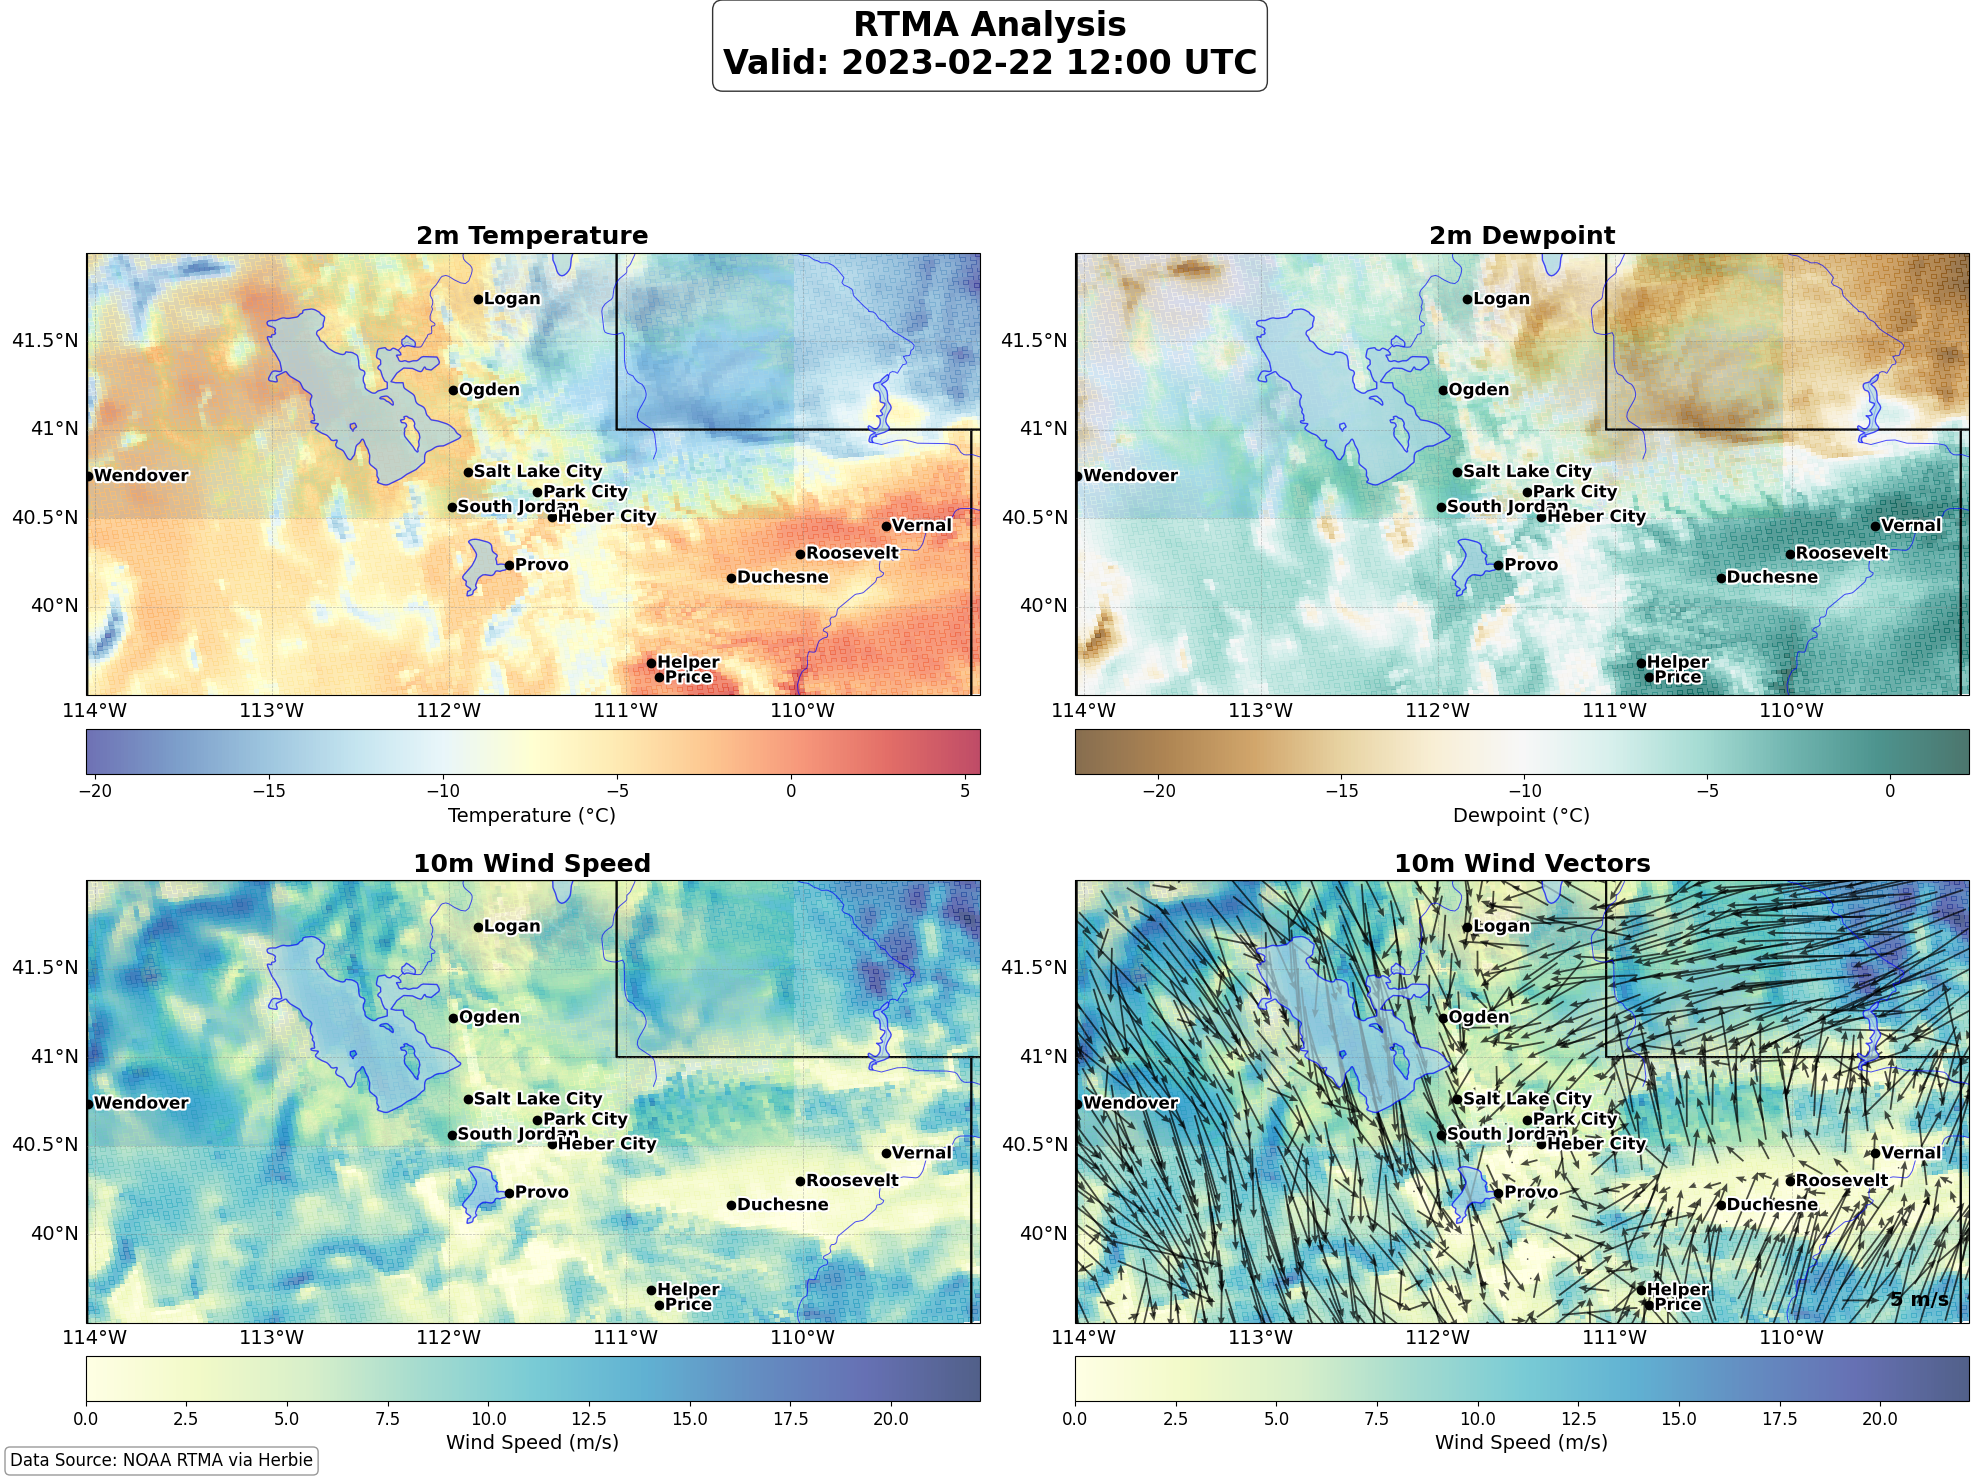


Script completed successfully with RTMA analysis.
Output saved to: ./rtma_analysis/rtma_analysis_2023-02-22_1200.png


In [2]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from herbie import Herbie
import numpy as np
import os
import xarray as xr
import pandas as pd
from datetime import datetime, timedelta
import warnings
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.patheffects as patheffects

# Set scientific style
plt.style.use('default')
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.titlesize': 24
})

warnings.filterwarnings('ignore')


def load_dem_data(lon_min, lon_max, lat_min, lat_max):
    """Load Digital Elevation Model (DEM) data for the given region."""
    import rasterio
    from rasterio.warp import transform_bounds

    dem_file = "/Users/a02428741/PycharmProjects/snowshadow/notebooks/uinta_dem_data/merged_dem.tif"

    if not os.path.exists(dem_file):
        return None, None, None

    with rasterio.open(dem_file) as src:
        # Transform the bounds to the CRS of the raster
        dst_crs = src.crs
        src_crs = 'EPSG:4326'  # WGS84
        transformed_bounds = transform_bounds(src_crs, dst_crs, lon_min, lat_min, lon_max, lat_max)

        # Read the data within the transformed bounds
        window = src.window(*transformed_bounds)
        dem = src.read(1, window=window)

        # Get the transform for the windowed data
        win_transform = src.window_transform(window)

        # Calculate longitude and latitude arrays
        height, width = dem.shape
        lon = np.linspace(win_transform.c, win_transform.c + width * win_transform.a, width)
        lat = np.linspace(win_transform.f, win_transform.f + height * win_transform.e, height)

        return dem, lon, lat


def extract_region_data(ds, var_name, bbox):
    """Extract region data for the specified dataset and variable."""
    if ds is None or var_name is None:
        return None, None, None

    lat_min, lon_min, lat_max, lon_max = bbox

    # Identify coordinate names
    if 'latitude' in ds.coords and 'longitude' in ds.coords:
        lat_coord, lon_coord = 'latitude', 'longitude'
    elif 'lat' in ds.coords and 'lon' in ds.coords:
        lat_coord, lon_coord = 'lat', 'lon'
    else:
        return None, None, None

    # Convert longitudes if necessary (RTMA uses 0-360 sometimes)
    if ds[lon_coord].min() > 180:
        ds = ds.assign_coords({lon_coord: (((ds[lon_coord] + 180) % 360) - 180)})

    # Check if coordinates are 1D or 2D
    if ds[lat_coord].ndim == 1 and ds[lon_coord].ndim == 1:
        # 1D coordinates can use direct selection
        ds_region = ds.sel({lat_coord: slice(lat_max, lat_min),
                            lon_coord: slice(lon_min, lon_max)})
    else:
        # 2D coordinates need to use masking
        lat_mask = (ds[lat_coord] >= lat_min) & (ds[lat_coord] <= lat_max)
        lon_mask = (ds[lon_coord] >= lon_min) & (ds[lon_coord] <= lon_max)
        combined_mask = lat_mask & lon_mask

        # Find the indices where the mask is True
        y_indices, x_indices = np.where(combined_mask)
        if len(y_indices) > 0 and len(x_indices) > 0:
            y_min, y_max = y_indices.min(), y_indices.max()
            x_min, x_max = x_indices.min(), x_indices.max()
            ds_region = ds.isel(y=slice(y_min, y_max + 1), x=slice(x_min, x_max + 1))
        else:
            ds_region = ds

    return ds_region, lat_coord, lon_coord


def get_valid_time_str(ds, date_str):
    """Get the valid time as string from dataset."""
    if ds is None:
        return date_str

    if hasattr(ds, 'valid_time'):
        valid_time = ds.valid_time
        if hasattr(valid_time, 'dt'):
            return valid_time.dt.strftime('%Y-%m-%d %H:%M UTC').item()
        else:
            return str(valid_time)
    elif 'time' in ds.coords:
        return str(ds['time'].values.item())
    else:
        return date_str


def setup_map_and_features(ax, bbox, projection, dem_data=None, dem_lon=None, dem_lat=None):
    """Setup the axes with basic map features and cities."""
    lat_min, lon_min, lat_max, lon_max = bbox

    # Set the extent
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=projection)

    # Add terrain first
    if dem_data is not None and dem_lon is not None and dem_lat is not None:
        # Use DEM data if available
        terrain = ax.pcolormesh(dem_lon, dem_lat, dem_data,
                                cmap='terrain', alpha=0.5,
                                transform=projection)
    else:
        # Use basic features instead of terrain
        ax.add_feature(cfeature.LAND.with_scale('10m'), facecolor='#edeae2')
        ax.add_feature(cfeature.OCEAN.with_scale('10m'), facecolor='lightblue')

    # Add other features
    ax.add_feature(cfeature.STATES.with_scale('10m'), edgecolor="black", linewidth=1.5, facecolor="none", alpha=0.8)
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), edgecolor="black", linewidth=1.5)
    ax.add_feature(cfeature.RIVERS.with_scale('10m'), edgecolor='blue', linewidth=0.7, alpha=0.7)
    ax.add_feature(cfeature.LAKES.with_scale('10m'), edgecolor='blue', facecolor='lightblue', alpha=0.7)

    # Add gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

    # Add cities
    cities = {
        # Salt Lake City area
        "Salt Lake City": (40.7608, -111.8910),
        "Ogden": (41.2230, -111.9738),
        "Provo": (40.2338, -111.6585),
        "Park City": (40.6461, -111.4980),
        "South Jordan": (40.5622, -111.9825),
        "Wendover": (40.7372, -114.0370),
        "Logan": (41.7370, -111.8338),
        # Uinta Basin
        "Duchesne": (40.1635, -110.4029),
        "Roosevelt": (40.2994, -110.0126),
        "Vernal": (40.4555, -109.5287),
        # Other notable locations
        "Price": (39.5994, -110.8107),
        "Heber City": (40.5068, -111.4168),
        "Helper": (39.6830, -110.8541)
    }

    for city, (lat, lon) in cities.items():
        if (lon >= lon_min and lon <= lon_max and lat >= lat_min and lat <= lat_max):
            ax.plot(lon, lat, 'ko', markersize=6, transform=projection)
            ax.text(lon, lat, f" {city}", fontsize=12,
                    transform=projection,
                    verticalalignment='center', fontweight='bold',
                    path_effects=[patheffects.withStroke(linewidth=3, foreground='white')])

    return ax


def extract_variable_data(H, search_string, expected_vars):
    """Extract data for a specific variable from RTMA."""
    result = H.xarray(search_string)

    # Handle if it returns a list of datasets
    if isinstance(result, list):
        for ds in result:
            for var in expected_vars:
                if var in ds.data_vars:
                    return ds, var
    else:
        ds = result
        if ds and len(ds.data_vars) > 0:
            for var in expected_vars:
                if var in ds.data_vars:
                    return ds, var
            # Use first variable if no expected variable found
            var = list(ds.data_vars)[0]
            return ds, var

    return None, None


def download_and_visualize_rtma(date_str, output_dir="./rtma_analysis",
                                bbox=(39.5, -114.05, 42.0, -109.0),
                                create_multiplot=True):
    """Download and visualize RTMA data for a specific date and bounding box."""
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Create a safe filename from the date string
    date_safe = date_str.replace(' ', '_').replace(':', '')

    # Extract bounding box coordinates
    lat_min, lon_min, lat_max, lon_max = bbox

    print(f"Downloading RTMA data for {date_str}...")

    # Initialize Herbie for RTMA model
    H = Herbie(date_str, model="rtma", product="anl", fxx=0)

    # Download the GRIB2 file
    file_path = H.download()

    if not os.path.exists(file_path):
        print(f"File download failed. File not found at: {file_path}")
        return

    # Get inventory to see available variables
    inventory = H.inventory()

    # Look for relevant variables
    temp_vars_info = []
    for idx, row in inventory.iterrows():
        var_name = row['variable']
        level = row['level']
        search_this = row['search_this']

        # Check for temperature, dewpoint, and wind related variables
        if ('TMP' in var_name or 'DPT' in var_name or 'UGRD' in var_name or
                'VGRD' in var_name or 'WIND' in var_name):
            search_string = f"{var_name}:{level}"
            if ':' in search_this:
                search_string = search_this
            temp_vars_info.append((var_name, level, search_string))

    if not temp_vars_info:
        print("No relevant variables found.")
        return

    print(f"Found {len(temp_vars_info)} relevant variables")

    # Extract temperature data
    tmp_ds, tmp_var = extract_variable_data(H, "TMP:2 m above ground", ['t2m'])
    if tmp_ds is not None and tmp_var is not None:
        data_min = float(tmp_ds[tmp_var].min().values)
        data_max = float(tmp_ds[tmp_var].max().values)
        print(f"Temperature data range: {data_min - 273.15:.2f}°C to {data_max - 273.15:.2f}°C")

    # Extract dewpoint data
    dpt_ds, dpt_var = extract_variable_data(H, "DPT:2 m above ground", ['d2m'])
    if dpt_ds is not None and dpt_var is not None:
        data_min = float(dpt_ds[dpt_var].min().values)
        data_max = float(dpt_ds[dpt_var].max().values)
        print(f"Dewpoint data range: {data_min - 273.15:.2f}°C to {data_max - 273.15:.2f}°C")

    # Extract wind data
    wind_ds, wind_var = extract_variable_data(H, "WIND:10 m above ground", ['si10'])
    if wind_ds is not None and wind_var is not None:
        data_min = float(wind_ds[wind_var].min().values)
        data_max = float(wind_ds[wind_var].max().values)
        print(f"Wind speed data range: {data_min:.2f} to {data_max:.2f} m/s")

    # Extract wind components for vector plotting
    u_ds, u_var = extract_variable_data(H, "UGRD:10 m above ground", ['u10'])
    v_ds, v_var = extract_variable_data(H, "VGRD:10 m above ground", ['v10'])

    # Check if we have any data
    if tmp_ds is None and dpt_ds is None and wind_ds is None:
        print("No valid RTMA data found for this date.")
        return

    # Extract region data for each dataset
    tmp_region, tmp_lat, tmp_lon = extract_region_data(tmp_ds, tmp_var, bbox)
    dpt_region, dpt_lat, dpt_lon = extract_region_data(dpt_ds, dpt_var, bbox)
    wind_region, wind_lat, wind_lon = extract_region_data(wind_ds, wind_var, bbox)

    # Extract wind components region data if available
    u_region, u_lat, u_lon = extract_region_data(u_ds, u_var, bbox) if u_ds is not None else (None, None, None)
    v_region, v_lat, v_lon = extract_region_data(v_ds, v_var, bbox) if v_ds is not None else (None, None, None)

    # Get the valid time string (use the first available dataset)
    for ds in [tmp_region, dpt_region, wind_region]:
        if ds is not None:
            valid_time_str = get_valid_time_str(ds, date_str)
            break
    else:
        valid_time_str = date_str

    # Load DEM data for the region
    dem_data, dem_lon, dem_lat = load_dem_data(lon_min, lon_max, lat_min, lat_max)

    # Create a multi-panel figure if requested
    if create_multiplot:
        print("Creating scientific multi-panel RTMA analysis...")

        # Determine how many panels we need
        panel_count = sum(x is not None for x in [tmp_region, dpt_region, wind_region])

        # Set up the figure and axes
        projection = ccrs.PlateCarree()

        if panel_count == 2:
            fig, axes = plt.subplots(1, 2, figsize=(20, 8),
                                     subplot_kw={'projection': projection})
            if not isinstance(axes, np.ndarray):
                axes = np.array([axes])
        else:
            # 2x2 grid for 3 or 4 panels
            fig, axes = plt.subplots(2, 2, figsize=(20, 16),
                                     subplot_kw={'projection': projection})
            axes = axes.flatten()

        # Initialize panel index
        panel_idx = 0

        # Process Temperature if available
        if tmp_region is not None and tmp_var is not None:
            ax = axes[panel_idx]
            panel_idx += 1

            # Setup map and features
            ax = setup_map_and_features(ax, bbox, projection, dem_data, dem_lon, dem_lat)

            # Convert to Celsius
            data_to_plot = tmp_region[tmp_var] - 273.15  # K to °C
            units = '°C'

            # Create colormap for temperature
            temp_cmap = plt.cm.get_cmap('RdYlBu_r')
            vmin = float(data_to_plot.min().values)
            vmax = float(data_to_plot.max().values)

            # Plot the data
            p = ax.pcolormesh(tmp_region[tmp_lon], tmp_region[tmp_lat], data_to_plot,
                              cmap=temp_cmap, transform=projection, vmin=vmin, vmax=vmax, alpha=0.7)

            # Add color bar
            cbar = plt.colorbar(p, ax=ax, orientation="horizontal", pad=0.05)
            cbar.set_label(f"Temperature ({units})", fontsize=14)
            cbar.ax.tick_params(labelsize=12)

            # Add title
            ax.set_title("2m Temperature", fontsize=18, fontweight='bold')

        # Process Dewpoint if available
        if dpt_region is not None and dpt_var is not None:
            ax = axes[panel_idx]
            panel_idx += 1

            # Setup map and features
            ax = setup_map_and_features(ax, bbox, projection, dem_data, dem_lon, dem_lat)

            # Convert to Celsius
            data_to_plot = dpt_region[dpt_var] - 273.15  # K to °C
            units = '°C'

            # Create colormap for dewpoint
            dpt_cmap = plt.cm.get_cmap('BrBG')
            vmin = float(data_to_plot.min().values)
            vmax = float(data_to_plot.max().values)

            # Plot the data
            p = ax.pcolormesh(dpt_region[dpt_lon], dpt_region[dpt_lat], data_to_plot,
                              cmap=dpt_cmap, transform=projection, vmin=vmin, vmax=vmax, alpha=0.7)

            # Add color bar
            cbar = plt.colorbar(p, ax=ax, orientation="horizontal", pad=0.05)
            cbar.set_label(f"Dewpoint ({units})", fontsize=14)
            cbar.ax.tick_params(labelsize=12)

            # Add title
            ax.set_title("2m Dewpoint", fontsize=18, fontweight='bold')

        # Process Wind Speed if available
        if wind_region is not None and wind_var is not None:
            ax = axes[panel_idx]
            panel_idx += 1

            # Setup map and features
            ax = setup_map_and_features(ax, bbox, projection, dem_data, dem_lon, dem_lat)

            # Wind speed data
            data_to_plot = wind_region[wind_var]  # already in m/s
            units = 'm/s'

            # Create colormap for wind speed
            wind_cmap = plt.cm.get_cmap('YlGnBu')
            vmin = float(data_to_plot.min().values)
            vmax = max(10, float(data_to_plot.max().values))  # Cap at 10 m/s or use max value

            # Plot the data
            p = ax.pcolormesh(wind_region[wind_lon], wind_region[wind_lat], data_to_plot,
                              cmap=wind_cmap, transform=projection, vmin=vmin, vmax=vmax, alpha=0.7)

            # Add color bar
            cbar = plt.colorbar(p, ax=ax, orientation="horizontal", pad=0.05)
            cbar.set_label(f"Wind Speed ({units})", fontsize=14)
            cbar.ax.tick_params(labelsize=12)

            # Add title
            ax.set_title("10m Wind Speed", fontsize=18, fontweight='bold')

        # Process Wind Vectors if available
        if u_region is not None and v_region is not None and u_var is not None and v_var is not None:
            ax = axes[panel_idx]
            panel_idx += 1

            # Setup map and features
            ax = setup_map_and_features(ax, bbox, projection, dem_data, dem_lon, dem_lat)

            # Calculate wind speed for background
            wind_speed = np.sqrt(u_region[u_var] ** 2 + v_region[v_var] ** 2)

            # Create 2D meshgrid of coordinates for proper plotting
            if u_region[u_lon].ndim == 1 and u_region[u_lat].ndim == 1:
                # For 1D coordinates, create a meshgrid
                lons2d, lats2d = np.meshgrid(u_region[u_lon], u_region[u_lat])
            else:
                # For 2D coordinates, use them directly
                lons2d, lats2d = u_region[u_lon], u_region[u_lat]

            # Thin the data for vector plotting
            ny, nx = u_region[u_var].shape
            thin = max(5, int(min(ny, nx) / 25))  # Aim for approximately 25-30 vectors across the domain

            # Plot the wind speed as colored contours first
            wind_cmap = plt.cm.get_cmap('YlGnBu')
            vmin = 0
            vmax = max(10, float(wind_speed.max().values))

            # Plot with pcolormesh
            p = ax.pcolormesh(
                lons2d, lats2d,
                wind_speed,
                cmap=wind_cmap,
                transform=projection,
                vmin=vmin,
                vmax=vmax,
                alpha=0.7
            )

            # Plot the wind vectors on top
            q = ax.quiver(
                lons2d[::thin, ::thin],
                lats2d[::thin, ::thin],
                u_region[u_var].values[::thin, ::thin],
                v_region[v_var].values[::thin, ::thin],
                transform=projection,
                scale=120,  # Adjust scale parameter as needed
                width=0.002,
                headwidth=4,
                color='black',
                alpha=0.7
            )

            # Add key for wind vectors
            plt.quiverkey(q, 0.9, 0.05, 5, '5 m/s',
                          labelpos='E', coordinates='axes',
                          fontproperties={'weight': 'bold'})

            # Add color bar
            cbar = plt.colorbar(p, ax=ax, orientation="horizontal", pad=0.05)
            cbar.set_label(f"Wind Speed (m/s)", fontsize=14)
            cbar.ax.tick_params(labelsize=12)

            # Add title
            ax.set_title("10m Wind Vectors", fontsize=18, fontweight='bold')

        # Set the overall title
        fig.suptitle(f"RTMA Analysis\nValid: {valid_time_str}",
                     fontsize=24, y=0.92, fontweight='bold',
                     bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

        # Adjust layout
        plt.tight_layout(rect=[0, 0, 1, 0.9])

        # Add data source information
        plt.figtext(0.01, 0.01, "Data Source: NOAA RTMA via Herbie", fontsize=12,
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

        # Save the figure
        output_file = os.path.join(output_dir, f"rtma_analysis_{date_safe}.png")
        plt.savefig(output_file, dpi=300, bbox_inches="tight")
        print(f"Scientific RTMA analysis saved as {output_file}")

        # Display the plot
        plt.show()

        return True

    return False


if __name__ == "__main__":
    # Create output directory
    output_dir = "./rtma_analysis"

    # Use February 22, 2023 as specified
    date_str = "2023-02-22 12:00"
    print(f"Using specified date: {date_str}")

    # Define a single bounding box that includes both SLC and Uinta Basin
    # Format: (lat_min, lon_min, lat_max, lon_max)
    utah_slc_uinta_bbox = (39.5, -114.05, 42.0, -109.0)

    # Run the analysis for the combined region
    print(f"Creating RTMA analysis for Utah region (including SLC and Uinta Basin) on {date_str}")
    download_and_visualize_rtma(date_str, output_dir, utah_slc_uinta_bbox, create_multiplot=True)

    print("\nScript completed successfully with RTMA analysis.")
    print(f"Output saved to: {output_dir}/rtma_analysis_2023-02-22_1200.png")